## 9.2 Mixture of Gaussians

高斯混合概率分布可用高斯分布的线性模型表示:
$$p(x)=\sum_{k=1}^K\pi_k\mathcal N(x|\mu_k,\Sigma_k)$$

引入二值变量$z_k\in\{0,1\}$且$\sum_kz_k=1$

$$p(z_k=1)=\pi_k$$
其中$\pi_k\in[0,1]$以及$\sum^K_{k=1}\pi_k=1$
$$p(z)=\prod_{k=1}^K\pi_k^{z_k}$$
x的条件概率分布就为:
$$p(x|z_k=1)=\mathcal N(x|\mu_k,\Sigma_k)$$
或:
$$p(x|z)=\prod_{k=1}^K\mathcal N(x|\mu_k,\Sigma_k)^{z_k}$$

x的边缘概率就为:
$$p(x)=\mathop\sum_{z}p(x|z)p(z)=\sum_{k=1}^K\pi_k\mathcal N(x|\mu_k,\Sigma_k)$$
潜在变量z让我们可以操作$p(x,z)$，而不是$p(x)$，把$\pi_k$视为$z_k=1$的先验概率，
把$\gamma(z_k)$视为观测到$x$以后，对应的后验概率

$$\begin{align}\gamma(z_k)\equiv p(z_k=1|x)&=\frac{p(z_k=1)p(x|z_k=1)}{\sum_{j=1}^Kp(z_j=1)p(x|z_j=1)}\\
&=\frac{\pi_k\mathcal N(x|\mu_k,\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(x|\mu_j,\Sigma_k)}\end{align}$$

$\gamma(z_k)$可以被视为分量k对于观测x的分类概率(不同类别在数据点上的比例)

## 9.2.2 EM algorithm for GMM

由$p(x)$的表示写出对数似然函数:
$$lnp(X|\pi,\mu,\Sigma)=\sum_{n=1}^N ln\bigg\{\sum_{k=1}^N\pi_k\mathcal N(x_n|\mu_K,\Sigma_k)\bigg\}$$
对$u_k$求导可得:$$\mu_k=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})x_n \tag {*}$$
其中$$N_k=\sum_{n=1}^N\gamma(z_{nk})$$
对$\Sigma_k$求导有:
$$\Sigma_k=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})(x_n-\mu_k)(x-\mu_k)^T\tag {*}$$
考虑限制条件，关于$\pi_k$最大化$lnp(X|\pi,\mu,\Sigma)$

$$lnp(X|\pi,\mu,,\Sigma)+\lambda(\sum_{k=1}^K\pi_k-1)$$
$$0=\sum_{n=1}^N\frac{\pi_k\mathcal N(x|\mu_k,\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(x|\mu_j,\Sigma_k)}+\lambda$$
利用$\sum^K_{k=1}\pi_k=1$可得:
$$\pi_k=\frac{N_k}{N}\tag {*}$$

### 总结如下:
* 初始化均值$u_k$,协防差$\Sigma_k$和混合系数$\pi_k$,计算似然对数初始值


* E-step:$$\gamma(z_{nk})=\frac{\pi_k\mathcal N(x_n|\mu_k,\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(x_n|\mu_j,\Sigma_k)}$$
* M-step:使用$\gamma(z_{nk})$估计参数。
$$\mu_k^{new}=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})x_n\\ 
\Sigma_k^{new}=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})(x_n-\mu_k^{new})(x_n-\mu_k^{new})^T\\
\pi_k^{new}=\frac{N_k}{N}\\
N_k=\sum_{n=1}^N\gamma(z_{nk})$$
* 计算对数似然$$lnp(X|\pi,\mu,\Sigma)=\sum_{n=1}^N ln\bigg\{\sum_{k=1}^N\pi_k\mathcal N(x_n|\mu_K,\Sigma_k)\bigg\}$$

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances_argmin
%matplotlib inline
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
np.random.seed(0)
mu1_fact = (0, 0, 0)
cov1_fact = np.diag((1, 2, 3))
data1 = np.random.multivariate_normal(mu1_fact, cov1_fact, 400)
mu2_fact = (2, 2, 1)
cov2_fact = np.array(((1, 1, 3), (1, 2, 1), (0, 0, 1)))
data2 = np.random.multivariate_normal(mu2_fact, cov2_fact, 100)
data = np.vstack((data1, data2))
y = np.array([True] * 400 + [False] * 100)

/home/leilichuan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


In [4]:
num_iter = 100
n, d = data.shape
        # initial randomly
        # mu1 = np.random.standard_normal(d)
        # print mu1
        # mu2 = np.random.standard_normal(d)
        # print mu2
mu1 = data.min(axis=0)
mu2 = data.max(axis=0)
sigma1 = np.identity(d)
sigma2 = np.identity(d)
pi = 0.5
# EM
for i in range(num_iter):
        # E Step
        norm1 = multivariate_normal(mu1, sigma1)
        norm2 = multivariate_normal(mu2, sigma2)
        tau1 = pi * norm1.pdf(data)
        tau2 = (1 - pi) * norm2.pdf(data)
        gamma = tau1 / (tau1 + tau2)

        # M Step
        mu1 = np.dot(gamma, data) / np.sum(gamma)
        mu2 = np.dot((1 - gamma), data) / np.sum((1 - gamma))
        sigma1 = np.dot(gamma * (data - mu1).T, data - mu1) / np.sum(gamma)
        sigma2 = np.dot((1 - gamma) * (data - mu2).T, data - mu2) / np.sum(1 - gamma)
        pi = np.sum(gamma) / n
        print (i, ":\t", mu1, mu2)
print ('Probability for class:\t', pi)
print ('Mean:\t', mu1, mu2)
print ('Cov:\n', sigma1, '\n\n', sigma2, '\n')

0 :	 [-0.05037552 -0.13148894 -0.38291219] [ 1.49842187  1.9291459   1.91700589]
1 :	 [-0.04388844 -0.09054836 -0.33142755] [ 1.49340903  1.82975771  1.78946115]
2 :	 [-0.04977111 -0.06641681 -0.2963213 ] [ 1.50886798  1.75884187  1.68690716]
3 :	 [-0.0609953  -0.04769542 -0.26368911] [ 1.538263    1.70214671  1.59016095]
4 :	 [-0.07482219 -0.03521687 -0.23219107] [ 1.57432266  1.66288371  1.49644801]
5 :	 [-0.08950239 -0.0288137  -0.20320453] [ 1.61172868  1.64025805  1.40957678]
6 :	 [-0.10355931 -0.02621278 -0.17725588] [ 1.64788169  1.62928876  1.33258483]
7 :	 [-0.11572301 -0.0253641  -0.15467575] [ 1.68037052  1.62507334  1.26705516]
8 :	 [-0.12519729 -0.02506102 -0.13558948] [ 1.70795872  1.62492468  1.21364344]
9 :	 [-0.13188589 -0.02486094 -0.11975807] [ 1.73118586  1.62816953  1.17181132]
10 :	 [-0.13618991 -0.02471794 -0.10683113] [ 1.75115204  1.63457337  1.14022593]
11 :	 [-0.1386616  -0.02465139 -0.09643256] [ 1.76870304  1.64356163  1.11721409]
12 :	 [-0.13980974 -0.0246

[0 1]
Accuracy：89.80%


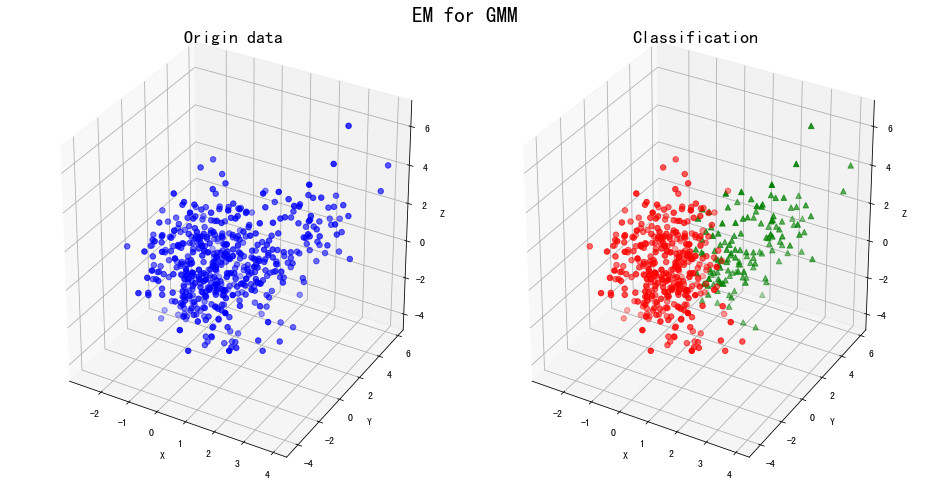

In [8]:
# 预测分类
norm1 = multivariate_normal(mu1, sigma1)
norm2 = multivariate_normal(mu2, sigma2)
tau1 = norm1.pdf(data)
tau2 = norm2.pdf(data)
fig = plt.figure(figsize=(13, 7), facecolor='w')
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', s=30, marker='o', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Origin data', fontsize=18)
ax = fig.add_subplot(122, projection='3d')
order = pairwise_distances_argmin([mu1_fact, mu2_fact], [mu1, mu2], metric='euclidean')
print( order)
if order[0] == 0:
     c1 = tau1 > tau2
else:
    c1 = tau1 < tau2
c2 = ~c1
acc = np.mean(y == c1)
print ('Accuracy：%.2f%%' % (100*acc))
ax.scatter(data[c1, 0], data[c1, 1], data[c1, 2], c='r', s=30, marker='o', depthshade=True)
ax.scatter(data[c2, 0], data[c2, 1], data[c2, 2], c='g', s=30, marker='^', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Classification', fontsize=18)
plt.suptitle('EM for GMM', fontsize=21)
plt.subplots_adjust(top=0.90)
plt.tight_layout()
plt.show()